In [42]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
import seaborn as sns

In [43]:
# 1. Load Data
df = pd.read_csv('Data_Manual.csv')

# 2. Preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text

df['clean_text'] = df['text'].apply(preprocess_text)

# Daftar stopword sederhana (Bahasa Indonesia)
stopwords_ind = [
    'dan', 'di', 'ke', 'dari', 'yang', 'pada', 'adalah', 'ini', 'itu', 'untuk',
    'bisa', 'ada', 'karena', 'kalau', 'jika', 'dengan', 'saya', 'kamu', 'dia',
    'mereka', 'kita', 'tidak', 'yg', 'ya', 'aja', 'aku', 'gak', 'bukan', 'sudah',
    'lagi', 'mau', 'akan', 'tapi', 'saja', 'juga', 'kok', 'kah', 'pun', 'n', 'tuh'
]

In [44]:
# K-Means

# 1. Vectorization dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_ind, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Fit K-Means (Misal: 3 Cluster)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Masukkan label cluster ke dataframe
df['cluster'] = kmeans.labels_

# Tampilkan kata kunci per cluster
print("cluster K-Means:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

cluster K-Means:
Cluster 0: versi, avanza, sedan, veloz, pake, vios, ga, toyota, mirip, gepenk
Cluster 1: keren, mobil, daihatsu, lebih, nya, taxi, harga, beli, banget, ga
Cluster 2: vios, gen, toyota, baru, keren, lebih, sekarang, jadi, ganteng, sama


In [45]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

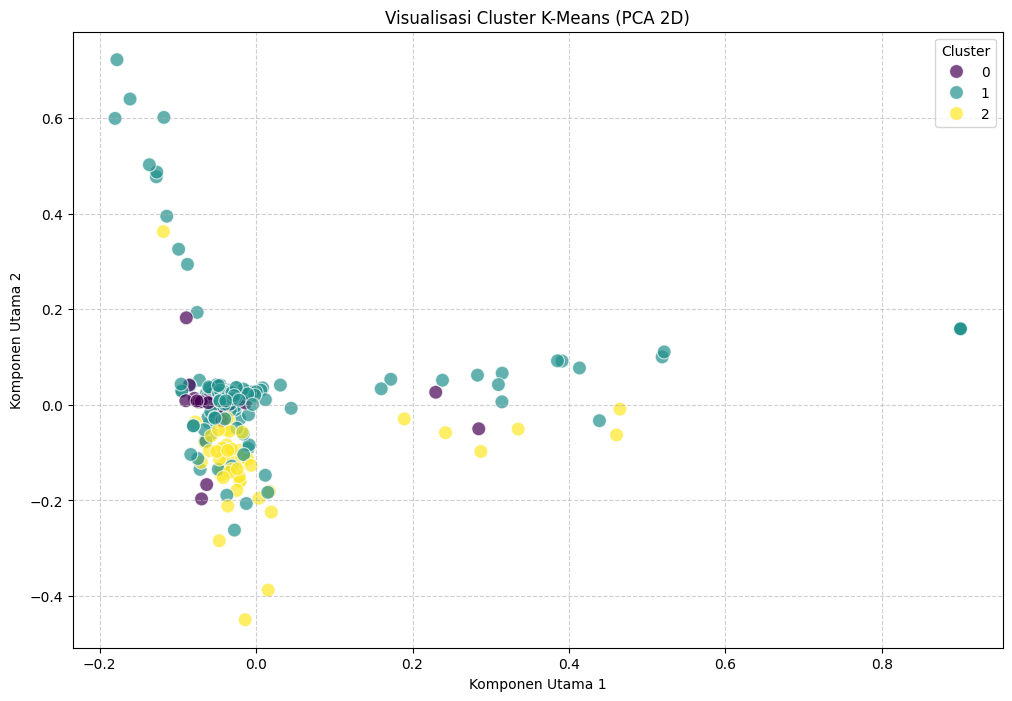

In [46]:
# 6. Plotting Visualisasi
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='cluster',
    palette='viridis',
    data=df,
    s=100,
    alpha=0.7,
    edgecolor='w'
)

plt.title('Visualisasi Cluster K-Means (PCA 2D)')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [47]:
# 3. TOPIC MODELLING (LDA)

# 4. Vectorization dengan Count Vectorizer (Bag of Words)
tf_vectorizer = CountVectorizer(stop_words=stopwords_ind, max_features=1000)
tf_matrix = tf_vectorizer.fit_transform(df['clean_text'])

# 5. Fit LDA (Misal: 3 Topik)
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tf_matrix)

# Tampilkan kata kunci per topik
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Top words LDA :")
print_top_words(lda, tf_vectorizer.get_feature_names_out(), 10)

Top words LDA :
Topic #0: vios nya lebih mobil gen bagus taxi banget masih belakang
Topic #1: keren daihatsu versi toyota beli classy sedan lebih udh avanza
Topic #2: vios mirip mobil veloz avanza toyota banget sih sama jadi


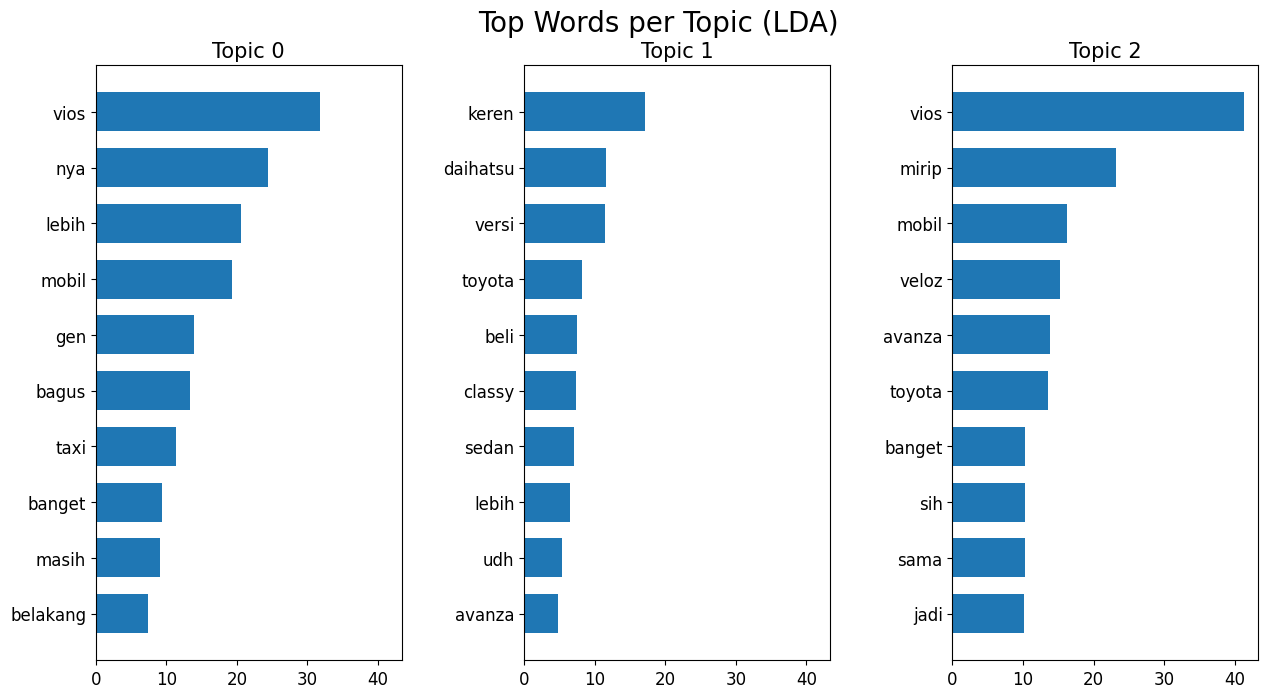

In [48]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # Mengambil indeks kata dengan bobot tertinggi
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 15})
        ax.invert_yaxis() # Kata terpenting di atas
        ax.tick_params(axis="both", which="major", labelsize=12)

    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.4)
    plt.show()

# Memanggil fungsi (lda dan tf_vectorizer dari kode sebelumnya)
words = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, words, 10, "Top Words per Topic (LDA)")

In [49]:
# Masukkan topik dominan ke dataframe
topic_values = lda.transform(tf_matrix)
df['topic'] = topic_values.argmax(axis=1)

# Simpan hasil
df.to_csv('data_manual_clustered_topics.csv', index=False)

In [50]:
# ELBOW

# 1. Vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_ind, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Hitung Elbow (Inertia untuk berbagai k)
inertias = []
K_range = range(1, 11)  # Coba k dari 1 sampai 10

print("Menghitung inertia:")
for k in K_range:
    # random_state agar hasil konsisten
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    print(f"k={k}, Inertia={kmeans.inertia_:.2f}")

Menghitung inertia:
k=1, Inertia=245.02
k=2, Inertia=242.48
k=3, Inertia=239.34
k=4, Inertia=236.85
k=5, Inertia=235.43
k=6, Inertia=232.48
k=7, Inertia=230.47
k=8, Inertia=230.37
k=9, Inertia=225.97
k=10, Inertia=224.69


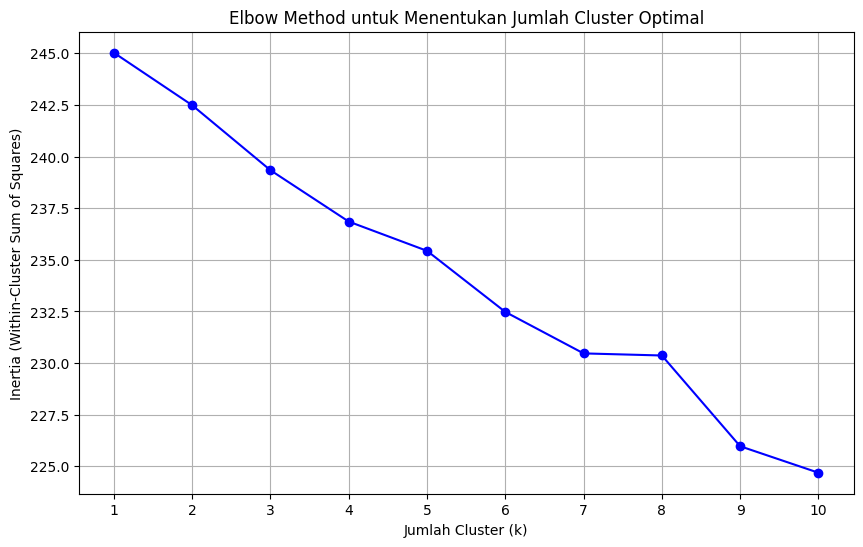

In [51]:
# 3. Plot Grafik Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()